<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/image_maker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import google.colab
import keras
google.colab.drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!git clone https://github.com/matterport/Mask_RCNN.git
%cd Mask_RCNN
!pip install -r requirements.txt
%run -i setup.py install
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!git clone https://github.com/waleedka/coco.git
%cd coco/PythonAPI
%run -i setup.py build_ext --inplace
%run -i setup.py build_ext install
%cd /content/Mask_RCNN

https://github.com/matterport/Mask_RCNN/blob/master/samples/demo.ipynb

In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
# sys.path.append(os.path.join(ROOT_DIR, "coco/PythonAPI"))  # To find local version
# import coco
from samples.coco import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [11]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [0]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# 共通関数

In [0]:
from PIL import Image, ImageFilter, ImageDraw, ImageFont
import google.colab
import os

IMG_ROOT = '/content/gdrive/My Drive/data/fashon_item_images'
EDITED_IMG_ROOT = '/content/gdrive/My Drive/data/edited_images'


def show_results(results):
  # Visualize results
  r = results[0]
  print(r['rois'])
  print(r['class_ids'])
  print(r['scores'])

def resize(img,new_hight,rate=1):
  width,height = img.size
  rate =  new_hight / height
  new_width = width * rate 
  return img.resize((int(new_width),int(new_hight)),Image.LANCZOS)
  
def resize_to_target(img,new_size):
  short ,long = img.size
  if short < long:
    rate =  new_size / short
    new_height = long * rate 
    new_width = new_size
  else:
    rate =  new_size / long
    new_width = short * rate 
    new_height = new_size
  
  return img.resize((int(new_width),int(new_height)),Image.LANCZOS)

def get_center(img):
  return int(img.size[0] / 2)

def shift_to(img_center,target_position):
  gap = img_center - target_position
  shift = gap * -1
  print('shift',shift)
  return shift  

def predict(image):
  array_image = keras.preprocessing.image.img_to_array(image)
  results = model.detect([array_image], verbose=1)
  return results

def get_object_center(image):
  results = predict(image)
  rois = results[0]['rois']
  height = image.size[0]
  width = image.size[1]
  center = width / 2
#   print(width,height)
#   print('center',center)
  max_area = 0
  for i in range(len(rois)):
#     print(rois[i])
    start_height = rois[i][0] 
    start_width = rois[i][1] 
    end_height = rois[i][2] 
    end_width = rois[i][3] 
    
    height = end_height - start_height
    width = end_width - start_width
    
    area = height * width
#     print('area',area)
    if area < max_area:continue
    max_area = area
    center = start_width + width / 2
#     print('update center',center)
    
  return int(center)

def get_object_center(image):
  results = predict(image)
  rois = results[0]['rois']
  height = image.size[0]
  width = image.size[1]
  x_center = width / 2
  y_center = height / 2

  max_area = 0
  for i in range(len(rois)):
#     print(rois[i])
    start_height = rois[i][0] 
    start_width = rois[i][1] 
    end_height = rois[i][2] 
    end_width = rois[i][3] 
    
    height = end_height - start_height
    width = end_width - start_width
    
    area = height * width
#     print('area',area)
    if area < max_area:continue
    max_area = area
    x_center = start_width + width / 2
    y_center = start_height + height / 2
#     print('update center',center)
  print('x,y',(int(x_center),int(y_center)))
  return (int(x_center),int(y_center))



def to_RGB(image):
  if image.mode == 'RGB':return image
  image.load() # required for png.split()
  background = Image.new("RGB", image.size, (255, 255, 255))
  background.paste(image, mask=image.split()[3]) # 3 is the alpha channel
  
  file_name = 'tmp.jpg'
  background.save(file_name, 'JPEG', quality=80)
  img = Image.open(file_name)
  return img

# 左右の画像加工

In [0]:
def left_right_image(left_img_path,right_img_path,  canvas_size = 500):
  # load image
  iml = Image.open(left_img_path)
  imr = Image.open(right_img_path)
  iml = to_RGB(iml)
  imr = to_RGB(imr)
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # target position
  left_target = int(canvas_size / 4 * 1)
  right_target = int(canvas_size / 4 * 3)
  # resize image   
  iml2 = resize(iml,canvas_size)
  imr2 = resize(imr,canvas_size)
  
  # get object centor
  iml2_center = get_object_center(iml2)[0]
  imr2_center = get_object_center(imr2)[0]
#   print('left_img_object_centor',iml2_center)
#   print('right_img_object_centor',imr2_center)

  # make mask
  mask_width = canvas_size / 2
  mask1 = Image.new("L",iml2.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((iml2_center - mask_width / 2, 0, canvas_size, canvas_size), fill=255)
  mask2 = Image.new("L",imr2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((imr2_center - mask_width / 2 ,0, imr2_center+ mask_width / 2, canvas_size), fill=255)

  # composite image 
  bg.paste(iml2,(shift_to(iml2_center,left_target),0),mask1)
  bg.paste(imr2,(shift_to(imr2_center,right_target),0),mask2)
  return bg

In [0]:

images = os.listdir(IMG_ROOT)
for i in range(1,11):#len(images)-1
  print('i',i)
  left_img_path = os.path.join(IMG_ROOT, images[i])
  right_img_path = os.path.join(IMG_ROOT, images[i+1])

  print('left_img_path',left_img_path)
  print('right_img_path',right_img_path)

  bg = left_right_image(left_img_path,right_img_path,500)
  plt.imshow(bg)
  file_name = f'left_right_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  saved_image.show()

# 3枚 画像加工

In [0]:
def left_right_up_down_image(left_img_path,right_up_img_path,right_down_img_path,  canvas_size = 500):
 
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # target position
  left_target = int(canvas_size / 10 * 3)
  right_target = int(canvas_size /10 * 8)
  
  # load image
  im1 = Image.open(left_img_path)
  im2 = Image.open(right_up_img_path)
  im3 = Image.open(right_down_img_path)
  
  im1 = to_RGB(im1)
  im2 = to_RGB(im2)
  im3 = to_RGB(im3)
  
  # resize image   
  im1 = resize(im1,canvas_size)
  im2 = resize_to_target(im2,canvas_size/20*10)
  im3 = resize_to_target(im3,canvas_size/20*10)
  
  # get object centor
  im1_center = get_object_center(im1)[0]
  im2_center = get_object_center(im2)[0]
  im3_center = get_object_center(im3)[0]
#   print('left_img_object_centor',iml2_center)
#   print('right_img_object_centor',imr2_center)

  # make mask
  mask_width = canvas_size / 2
  mask1 = Image.new("L",im1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((im1_center - mask_width / 10 * 6, 0, im1.size[0], im1.size[1]), fill=255)
  mask2 = Image.new("L",im2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((im2_center - mask_width  / 10 * 4 ,0, im2.size[0], canvas_size/2), fill=255)
  mask3 = Image.new("L",im3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((im3_center - mask_width / 10 * 4 ,0, im3.size[0], im3.size[1]), fill=255)
  
  # composite image 
  bg.paste(im1,(shift_to(im1_center,left_target),0),mask1)
  bg.paste(im2,(shift_to(im2_center,right_target),0),mask2)
  bg.paste(im3,(shift_to(im3_center,right_target),int(canvas_size/2)),mask3)
  return bg



left_img_path /content/gdrive/My Drive/data/fashon_item_images/38c77bbc7fd33f6981234bfe1f1472ca.jpg
right_up_img_path /content/gdrive/My Drive/data/fashon_item_images/b6a716f6c21ae992d5cf84c73ff1081e.jpg
right_down_img_path /content/gdrive/My Drive/data/fashon_item_images/d14fb267d908c2cb53b977cd4bbf30a0.jpg
Processing 1 images
image                    shape: (500, 747, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (331, 261)
Processing 1 images
image                    shape: (250, 373, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min: 

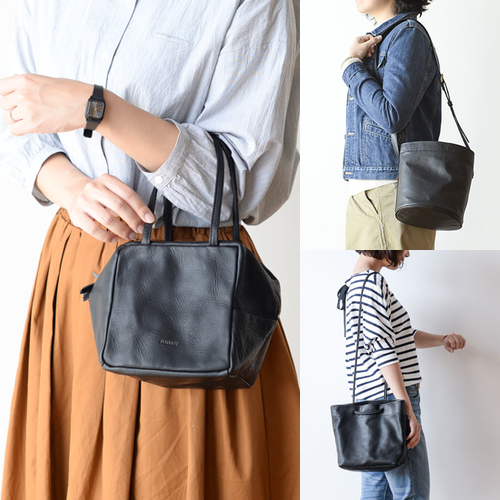

In [102]:
images = os.listdir(IMG_ROOT)
for i in range(40,len(images)-2,4):
  left_img_path = os.path.join(IMG_ROOT, images[i])
  right_up_img_path = os.path.join(IMG_ROOT, images[i+1])
  right_down_img_path = os.path.join(IMG_ROOT, images[i+2])
  
  print('left_img_path',left_img_path)
  print('right_up_img_path',right_up_img_path)
  print('right_down_img_path',right_down_img_path)

  bg = left_right_up_down_image(left_img_path,right_up_img_path,right_down_img_path,  canvas_size = 500)
  file_name = f'3layout_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  break
saved_image
  


# 横3枚の画像加工

In [0]:
def left_middle_right_image(left_img_path,middle_img_path,right_img_path,  canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(left_img_path)
  im2 = Image.open(middle_img_path)
  im3 = Image.open(right_img_path)
  
  im1 = to_RGB(im1)
  im2 = to_RGB(im2)
  im3 = to_RGB(im3)  
  # resize image   
  rim1 = resize(im1,canvas_size)
  rim2 = resize(im2,canvas_size)
  rim3 = resize(im3,canvas_size)
  
  # get object centor
  rim1_center = get_object_center(rim1)[0]
  rim2_center = get_object_center(rim2)[0]
  rim3_center = get_object_center(rim3)[0]
#   print('left_img_object_centor',iml2_center)
#   print('right_img_object_centor',imr2_center)

  # make mask
  mask_width = canvas_size / 3
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((rim1_center - mask_width / 2, 0, canvas_size, canvas_size), fill=255)
  mask2 = Image.new("L",rim2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((rim2_center - mask_width / 2 ,0, rim2_center+ mask_width / 2, canvas_size), fill=255)
  mask3 = Image.new("L",rim3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((rim3_center - mask_width / 2 ,0, rim3_center+ mask_width / 2, canvas_size), fill=255)

  # target position
  left_target = int(canvas_size / 6 * 1)
  middle_target = int(canvas_size / 6 * 3)
  right_target = int(canvas_size / 6 * 5)
  
  # composite image 
  bg.paste(rim1,(shift_to(rim1_center,left_target),0),mask1)
  bg.paste(rim2,(shift_to(rim2_center,middle_target),0),mask2)
  bg.paste(rim3,(shift_to(rim3_center,right_target),0),mask3)
  return bg

left_img_path /content/gdrive/My Drive/data/fashon_item_images/20170208155021334_500.jpg
middle_img_path /content/gdrive/My Drive/data/fashon_item_images/6de89f7b-1fdb-4efe-9ffa-56ab7af3e0cd.jpg
right_img_path /content/gdrive/My Drive/data/fashon_item_images/WS000014-9.jpg
Processing 1 images
image                    shape: (500, 374, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (245, 256)
Processing 1 images
image                    shape: (500, 418, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64

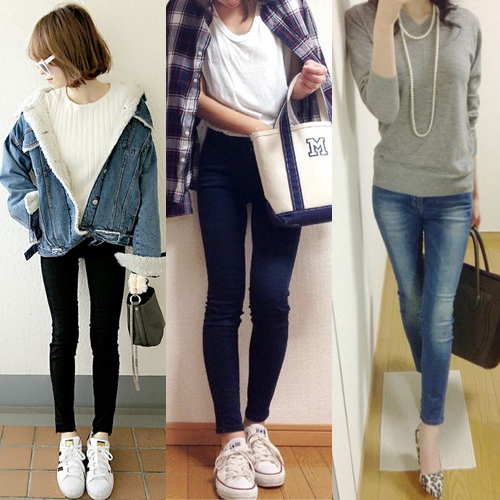

In [104]:
images = os.listdir(IMG_ROOT)
for i in range(49,len(images)-3):
  left_img_path = os.path.join(IMG_ROOT, images[i])
  middle_img_path = os.path.join(IMG_ROOT, images[i+1])
  right_img_path = os.path.join(IMG_ROOT, images[i+2])
  
  print('left_img_path',left_img_path)
  print('middle_img_path',middle_img_path)
  print('right_img_path',right_img_path)

  bg = left_middle_right_image(left_img_path,middle_img_path,right_img_path,  canvas_size = 500)
  file_name = f'3line_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  break
saved_image
  

# 縦4枚の画像加工

In [0]:
def split_4line_image(img1_path, img2_path, img3_path, img4_path, canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(img1_path)
  im2 = Image.open(img2_path)
  im3 = Image.open(img3_path)
  im4 = Image.open(img4_path)
  
  im1 = to_RGB(im1)
  im2 = to_RGB(im2)
  im3 = to_RGB(im3)  
  im4 = to_RGB(im4)  
  # resize image   
  rim1 = resize(im1,canvas_size)
  rim2 = resize(im2,canvas_size)
  rim3 = resize(im3,canvas_size)
  rim4 = resize(im4,canvas_size)
  
  # get object centor
  rim1_center = get_object_center(rim1)[0]
  rim2_center = get_object_center(rim2)[0]
  rim3_center = get_object_center(rim3)[0]
  rim4_center = get_object_center(rim4)[0]

  # make mask
  mask_width = canvas_size / 4
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((rim1_center - mask_width / 2, 0, canvas_size, canvas_size), fill=255)
  mask2 = Image.new("L",rim2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((rim2_center - mask_width / 2 ,0, canvas_size, canvas_size), fill=255)
  mask3 = Image.new("L",rim3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((rim3_center - mask_width / 2 ,0, canvas_size, canvas_size), fill=255)
  mask4 = Image.new("L",rim4.size,0)
  draw4 = ImageDraw.Draw(mask4)
  draw4.rectangle((rim4_center - mask_width / 2 ,0, canvas_size, canvas_size), fill=255)

  # target position
  target_1 = int(canvas_size / 8 * 1)
  target_2 = int(canvas_size / 8 * 3)
  target_3 = int(canvas_size / 8 * 5)
  target_4 = int(canvas_size / 8 * 7)
  
  print(target_1,target_2,target_3,target_4)
  
  # composite image 
  bg.paste(rim1,(shift_to(rim1_center,target_1),0),mask1)
  bg.paste(rim2,(shift_to(rim2_center,target_2),0),mask2)
  bg.paste(rim3,(shift_to(rim3_center,target_3),0),mask3)
  bg.paste(rim4,(shift_to(rim4_center,target_4),0),mask4)
  return bg

image_1 /content/gdrive/My Drive/data/fashon_item_images/fe11e8ef-b0b0-49ec-894d-2239649099d8.png
image_2 /content/gdrive/My Drive/data/fashon_item_images/181419_3.jpg
image_3 /content/gdrive/My Drive/data/fashon_item_images/jocee.jpc7a1b29215cacced1ece36511-89b9b92b20f5b6cafa890578717d4750be3eccda.jpg
image_4 /content/gdrive/My Drive/data/fashon_item_images/unnamed.jpg
Processing 1 images
image                    shape: (500, 402, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (259, 248)
Processing 1 images
image                    shape: (500, 500, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  floa

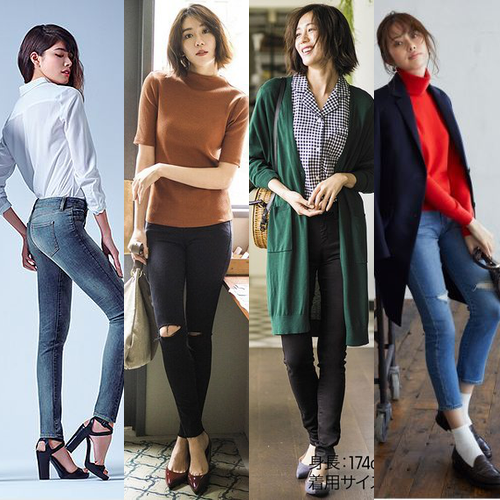

In [106]:
images = os.listdir(IMG_ROOT)
for i in range(52,len(images)-4,4):
  image_1 = os.path.join(IMG_ROOT, images[i])
  image_2 = os.path.join(IMG_ROOT, images[i+1])
  image_3 = os.path.join(IMG_ROOT, images[i+2])
  image_4 = os.path.join(IMG_ROOT, images[i+3])
  
  print('image_1',image_1)
  print('image_2',image_2)
  print('image_3',image_3)
  print('image_4',image_4)

  bg = split_4line_image(image_1,image_2,image_3,image_4,  canvas_size = 500)
  file_name = f'4line_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  break
saved_image


# 正方形4面


Processing 1 images
image                    shape: (319, 250, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.95832  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (181, 156)
Processing 1 images
image                    shape: (319, 250, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.21736  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (175, 153)
Processing 1 images
image                    shape: (319, 250, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024

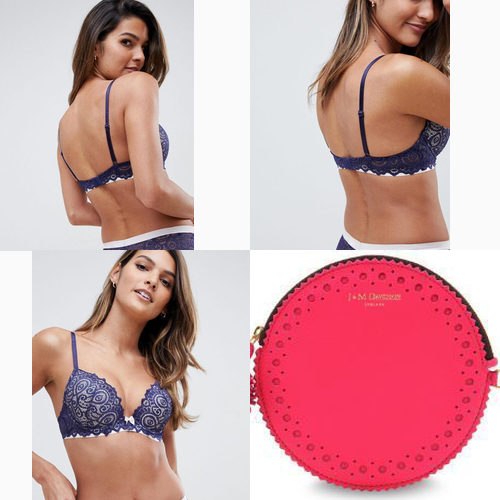

In [126]:
def square_4image(img1_path, img2_path, img3_path, img4_path, canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(img1_path)
  im2 = Image.open(img2_path)
  im3 = Image.open(img3_path)
  im4 = Image.open(img4_path)
  
  im1 = to_RGB(im1)
  im2 = to_RGB(im2)
  im3 = to_RGB(im3)  
  im4 = to_RGB(im4)  
  # resize image   
#   rim1 = resize(im1,canvas_size/2)
#   rim2 = resize(im2,canvas_size/2)
#   rim3 = resize(im3,canvas_size/2)
#   rim4 = resize(im4,canvas_size/2)  
  
  rim1 = resize_to_target(im1,canvas_size/2)
  rim2 = resize_to_target(im2,canvas_size/2)
  rim3 = resize_to_target(im3,canvas_size/2)
  rim4 = resize_to_target(im4,canvas_size/2)
  
  # get object centor
  rim1_center = get_object_center(rim1)
  rim2_center = get_object_center(rim2)
  rim3_center = get_object_center(rim3)
  rim4_center = get_object_center(rim4)

  mask_width = canvas_size / 2
  
  
  # target position
  target_1 = int(canvas_size / 4 * 1)
  target_2 = int(canvas_size / 4 * 3)
  target_3 = int(canvas_size / 4 * 1)
  target_4 = int(canvas_size / 4 * 3)
  
  # make mask
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((rim1_center[0] - mask_width, 0, rim1_center[0] + mask_width /2 , canvas_size/2), fill=255)
  mask2 = Image.new("L",rim2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((rim2_center[0] - mask_width / 2,0, canvas_size, canvas_size/2), fill=255)
  mask3 = Image.new("L",rim3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((rim3_center[0] - mask_width ,0, rim3_center[0] + mask_width /2, canvas_size), fill=255)
  mask4 = Image.new("L",rim4.size,0)
  draw4 = ImageDraw.Draw(mask4)
  draw4.rectangle((rim4_center[0] - mask_width / 2 ,0, canvas_size, canvas_size), fill=255)


  
  print(target_1,target_2,target_3,target_4)
  
  # composite image 
  bg.paste(rim1,(shift_to(rim1_center[0],target_1),0),mask1)
  bg.paste(rim2,(shift_to(rim2_center[0],target_2),0),mask2)
  bg.paste(rim3,(shift_to(rim3_center[0],target_3),int(canvas_size / 2)),mask3)
  bg.paste(rim4,(shift_to(rim4_center[0],target_4),int(canvas_size / 2)),mask4)
  return bg
i = 94
image_1 = os.path.join(IMG_ROOT, images[i])
image_2 = os.path.join(IMG_ROOT, images[i+1])
image_3 = os.path.join(IMG_ROOT, images[i+2])
image_4 = os.path.join(IMG_ROOT, images[i+3])
square_4image(image_1,image_2,image_3,image_4,  canvas_size = 500)

image_1 /content/gdrive/My Drive/data/fashon_item_images/a04 3.jpg
image_2 /content/gdrive/My Drive/data/fashon_item_images/a01 3.jpg
image_3 /content/gdrive/My Drive/data/fashon_item_images/a02 3.jpg
image_4 /content/gdrive/My Drive/data/fashon_item_images/a03 3.jpg
Processing 1 images
image                    shape: (333, 250, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (124, 131)
Processing 1 images
image                    shape: (333, 250, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
ancho

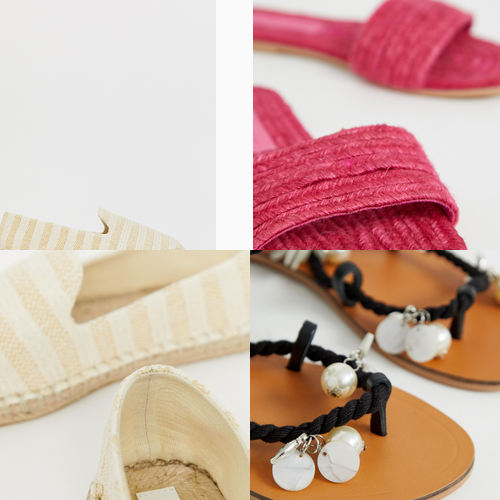

In [127]:
images = os.listdir(IMG_ROOT)


for i in range(0,len(images)-4,8):
  image_1 = os.path.join(IMG_ROOT, images[i])
  image_2 = os.path.join(IMG_ROOT, images[i+1])
  image_3 = os.path.join(IMG_ROOT, images[i+2])
  image_4 = os.path.join(IMG_ROOT, images[i+3])
  
  print('image_1',image_1)
  print('image_2',image_2)
  print('image_3',image_3)
  print('image_4',image_4)

  bg = square_4image(image_1,image_2,image_3,image_4,  canvas_size = 500)
  file_name = f'4square_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  if i == 10:break
saved_image

## 上1 下2 

Processing 1 images
image                    shape: (500, 500, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (241, 243)
Processing 1 images
image                    shape: (250, 250, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (125, 125)
Processing 1 images
image                    shape: (328, 250, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024

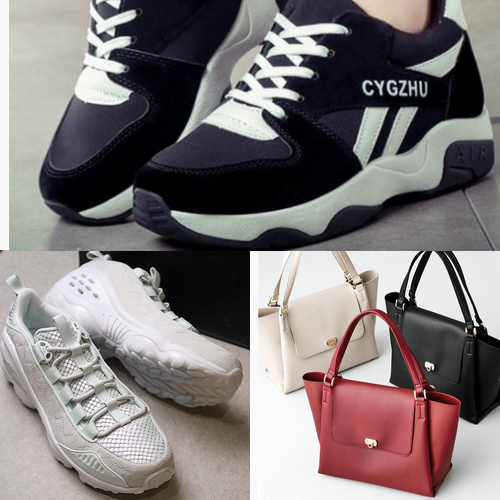

In [204]:
def upper1_lower2_image(img1_path, img2_path, img3_path, canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(img1_path)
  im2 = Image.open(img2_path)
  im3 = Image.open(img3_path)
  
  im1 = to_RGB(im1)
  im2 = to_RGB(im2)
  im3 = to_RGB(im3)  

  # resize image   
  rim1 = resize_to_target(im1,canvas_size)
  rim2 = resize_to_target(im2,canvas_size/2)
  rim3 = resize_to_target(im3,canvas_size/2)
  
  # get object centor
  rim1_center = get_object_center(rim1)
  rim2_center = get_object_center(rim2)
  rim3_center = get_object_center(rim3)

  # make mask
  mask_width = canvas_size
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((0, rim1_center[1] - mask_width / 2, canvas_size, rim1_center[1] + mask_width / 2), fill=255)
  
  mask2 = Image.new("L",rim2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((0 ,0, canvas_size, canvas_size), fill=255)
  
  mask3 = Image.new("L",rim3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((rim3_center[0] - mask_width / 2 ,0, canvas_size, canvas_size), fill=255)
  
  # target position
  target_x_1 = int(canvas_size / 2)
  target_x_3 = int(canvas_size / 4 * 3)
  target_y_2 = int(canvas_size / 4 * 3)
  target_y_3 = int(canvas_size / 4 * 3)
  
  print(target_x_1,target_x_3)
  print(target_y_2,target_y_3)
  
  # composite image 
  bg.paste(rim2,(0,shift_to(rim2_center[1],target_y_2)),mask2)
  bg.paste(rim3,(shift_to(rim3_center[0],target_x_3),shift_to(rim3_center[1],target_y_3)),mask3)
  bg.paste(rim1,(shift_to(rim1_center[0],target_x_1),shift_to(rim1_center[1],0)),mask1)
  return bg


i=33
image_1 = os.path.join(IMG_ROOT, images[i])
image_2 = os.path.join(IMG_ROOT, images[i+1])
image_3 = os.path.join(IMG_ROOT, images[i+2])

bg = upper1_lower2_image(image_1,image_2,image_3,  canvas_size = 500)
file_name = f'u1_l2_{i}.png'
save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
bg.save(save_file_path)
saved_image = Image.open(save_file_path)
saved_image

In [0]:
images = os.listdir(IMG_ROOT)
for i in range(0,len(images)-1,3):
  image_1 = os.path.join(IMG_ROOT, images[i])
  image_2 = os.path.join(IMG_ROOT, images[i+1])
  image_3 = os.path.join(IMG_ROOT, images[i+2])
  
  print('image_1',image_1)
  print('image_2',image_2)

  bg = upper1_lower2_image(image_1,image_2,image_3,  canvas_size = 500)
  file_name = f'u1_l2_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
  if i == 10:break
#   break
saved_image

## 上2 下1

In [1]:
def upper1_lower2_image(img1_path, img2_path, img3_path, canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(img1_path)
  im2 = Image.open(img2_path)
  im3 = Image.open(img3_path)
  
  im1 = to_RGB(im1)
  im2 = to_RGB(im2)
  im3 = to_RGB(im3)  

  # resize image   
  rim1 = resize_to_target(im1,canvas_size/2)
  rim2 = resize_to_target(im2,canvas_size/2)
  rim3 = resize_to_target(im3,canvas_size)
  
  # get object centor
  rim1_center = get_object_center(rim1)
  rim2_center = get_object_center(rim2)
  rim3_center = get_object_center(rim3)

  # make mask
  mask_width = canvas_size / 2
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((0, rim1_center[1] - mask_width, rim1_center[0] + mask_width, rim1_center[1] + mask_width), fill=255)
  
  mask2 = Image.new("L",rim2.size,0)
  draw2 = ImageDraw.Draw(mask2)
  draw2.rectangle((rim2_center[0] - mask_width ,0, rim2_center[0] + mask_width, rim2_center[1] + mask_width), fill=255)
  
  mask3 = Image.new("L",rim3.size,0)
  draw3 = ImageDraw.Draw(mask3)
  draw3.rectangle((0 ,rim3_center[1] - mask_width, canvas_size, rim3_center[1] + mask_width), fill=255)
  
  # target position
  target_x_1 = int(canvas_size / 4 * 1)
  target_x_2 = int(canvas_size / 4 * 3)
  target_y_1 = int(canvas_size / 4 * 1)
  target_y_2 = int(canvas_size / 4 * 1)
  target_y_3 = int(canvas_size / 10 * 10)
  
  print(target_x_1,target_x_2)
  print(target_y_1,target_y_2,target_y_3)
  
  # composite image 
  bg.paste(rim1,(shift_to(rim1_center[0],target_x_1),shift_to(rim1_center[1],target_y_1)),mask1)
  bg.paste(rim2,(shift_to(rim2_center[0],target_x_2),shift_to(rim2_center[1],target_y_2)),mask2)
  bg.paste(rim3,(0,shift_to(rim3_center[1],target_y_3)),mask3)
  return bg


i=90
image_1 = os.path.join(IMG_ROOT, images[i])
image_2 = os.path.join(IMG_ROOT, images[i+1])
image_3 = os.path.join(IMG_ROOT, images[i+2])

bg = upper1_lower2_image(image_1,image_2,image_3,  canvas_size = 500)
file_name = f'u1_l2_{i}.png'
save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
bg.save(save_file_path)
saved_image = Image.open(save_file_path)
saved_image

NameError: ignored

image_1 /content/gdrive/My Drive/data/fashon_item_images/a04 3.jpg
image_2 /content/gdrive/My Drive/data/fashon_item_images/a01 3.jpg
Processing 1 images
image                    shape: (333, 250, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (124, 131)
Processing 1 images
image                    shape: (333, 250, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
x,y (76, 123)
Processing 1 images
image    

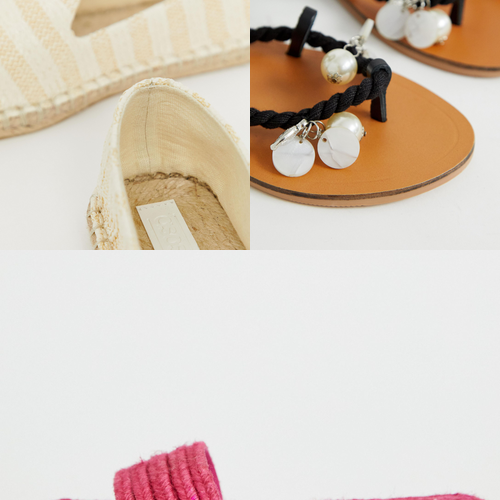

In [207]:
images = os.listdir(IMG_ROOT)
for i in range(0,len(images)-1,3):
  image_1 = os.path.join(IMG_ROOT, images[i])
  image_2 = os.path.join(IMG_ROOT, images[i+1])
  image_3 = os.path.join(IMG_ROOT, images[i+2])
  
  print('image_1',image_1)
  print('image_2',image_2)

  bg = upper1_lower2_image(image_1,image_2,image_3,  canvas_size = 500)
  file_name = f'u2_l1_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
  saved_image = Image.open(save_file_path)
#   if i == 10:break
#   break
saved_image

# 左右1:2 

In [0]:
def split1_2(left_img_path,right_img_path,  canvas_size = 500):
  # make back ground
  bg = Image.new("RGB",(canvas_size,canvas_size),(250,250,250))
  
  # load image
  im1 = Image.open(left_img_path)
  im3 = Image.open(right_img_path)
  
  im1 = to_RGB(im1)
  im3 = to_RGB(im3)  
  # resize image   
  rim1 = resize(im1,canvas_size)
  rim3 = resize(im3,canvas_size)
  
  # get object centor
  rim1_center = get_object_center(rim1)
  rim3_center = get_object_center(rim3)
#   print('left_img_object_centor',iml2_center)
#   print('right_img_object_centor',imr2_center)
  
  # target position
  left_target = int(canvas_size / 6 * 1)
  right_target = int(canvas_size / 6 * 4)

  shift1 = shift_to(rim1_center,left_target)
  shift3 = shift_to(rim3_center,right_target)
  mask_edge = rim1_center + left_target
  print('mask edge',mask_edge)
  print('1/3',canvas_size / 3)
  # make mask
  mask_width = canvas_size / 3 * 2
  mask1 = Image.new("L",rim1.size,0)
  draw1 = ImageDraw.Draw(mask1)
  draw1.rectangle((0, 0, mask_edge, canvas_size), fill=255)

  # composite image 
  bg.paste(rim3,(shift3,0))
  bg.paste(rim1,(shift1,0),mask1)
  return bg

In [0]:
images = os.listdir(IMG_ROOT)
i = 11
for i in range(0,len(images)-1):
  left_img_path = os.path.join(IMG_ROOT, images[i])
  right_img_path = os.path.join(IMG_ROOT, images[i+1])
  
  print('left_img_path',left_img_path)
  print('right_img_path',right_img_path)

  bg = split1_2(left_img_path,right_img_path,  canvas_size = 500)
  file_name = f'split1_2_{i}.png'
  save_file_path = os.path.join(EDITED_IMG_ROOT,file_name) 
  bg.save(save_file_path)
saved_image = Image.open(save_file_path)
saved_image
  